# Counting Cells with Cellpose

In this notebook we will be using the cellpose package to segment and count cells from the INS1_BF dataset.

TODO:

- process notebook into a single python file than into an excutable for easier use by the rest of the lab


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns
import skimage.io
import glob
import re # REEEEEE

import cellpose

from cellpose import models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from progress.bar import Bar

PATH = 'data/INS1_BF/*/*.tiff' # super path
reg = r'\/([0-9]*)\/3765_([A-Z][0-9]{2})_T0001F001L01A01Z01C01' # change for vars later

In [2]:
files = glob.glob(PATH)
print(type(files))
print(len(files))

<class 'list'>
384


In [3]:
# columns=['filename', 'max', 'min','mean', 'Q1', 'Q3']
# sub dirsf
model = models.Cellpose(gpu=True, model_type='cyto')
dirs = glob.glob('data/INS1_BF/*')
print(dirs)

** TORCH CUDA version installed and working. **
>>>> using GPU
['data/INS1_BF/6000', 'data/INS1_BF/4000', 'data/INS1_BF/2000', 'data/INS1_BF/10000', 'data/INS1_BF/8000', 'data/INS1_BF/0']


In [4]:
def get_meta(filename, reg):
    data = re.split(reg, filename)
    return (data[1:3]) 

In [47]:
def gen_data(path, model, reg):
    """
    creates data from a list of directories generated into a dict to convert to a pandas dataframe
    PARAMS:
        path - directory of data
        model - cellpose model
    RETURN:
        data - pandas dataframe of filename, groupID, wellID, counts
    """
    files = glob.glob(path+'/*.tif')
    
    data = {
        'filename':[],
        'groupID':[],
        'wellID':[],
        'counts':[]
    }
    
    for f in files:
        groupID, wellID = get_meta(f, reg) # data from filename
        img = skimage.io.imread(f) 
        masks, flows, styles, diams = model.eval(img, diameter=None, channels=[0,0],  do_3D=False)        
        masks=np.array(masks) # convert to numpy array
        count = masks.max()
        
        # append data into dict
        data['filename'].append(f)
        data['groupID'].append(groupID)
        data['wellID'].append(wellID)
        data['counts'].append(count)
    
    df = pd.DataFrame.from_dict(data)
    
    return df

In [6]:
def create_df(dirs):
    """
    creates dataframe of cell data from list of directories
    args:
        dirs - list of directories
    reutrn:
        df - dataframe of cell data: filename, groupID, wellID, counts
    TODO:
        - add optional columns
        - add optional file types
    """
    col_names = ['filename','groupID','wellID','counts']
    df = pd.DataFrame(columns=col_names)
    for i, d in enumerate(dirs):
        print(f'\n\nGetting data from {d}\n\n')
        data = gen_data(d, model)
        df = df.append(data)
    return df

In [39]:
def linear_regression(df, filename):
    """
    runs linear regression and generates graph and R^2 values 
    args:
        df - pandas dataframe of data
        filename - filename of linear regression plot
    returns:
        ax - plot for showing
        fig - figure for saving
    """
    X = df.groupID.values.reshape(-1,1)
    Y = df.counts.values.reshape(-1,1)
    
    lr = LinearRegression()
    lr.fit(X,Y)
    y_pred = lr.predict(X)
    
    rs=r2_score(Y, y_pred)

    fig, ax = plt.subplots()

    ax.scatter(X, Y)
    ax.plot(x, y_pred, color='red')
    ax.set_xlabel('Real counts')
    ax.set_ylabel('Predicted Count')

    ax.set_title("R2: {:.3f}".format(round(rs, 3)))

    plt.show()

    fig.savefig(filename,dpi=fig.dpi)
    
    return (ax, fig)

In [10]:
df = pd.read_csv('mask_data.csv')
df.head
box_plot = sns.boxplot(x='groupID', y='counts', data=df)
fig = box_plot.get_figure()
fig.savefig('boxplot.png')
df.to_csv('mask_data.csv', index=False)
df.dtypes

<bound method NDFrame.head of                                               filename  groupID wellID  counts
0    data/INS1_BF/6000/3765_D10_T0001F001L01A01Z01C...     6000    D10     700
1    data/INS1_BF/6000/3765_O09_T0001F001L01A01Z01C...     6000    O09     626
2    data/INS1_BF/6000/3765_J12_T0001F001L01A01Z01C...     6000    J12     628
3    data/INS1_BF/6000/3765_N10_T0001F001L01A01Z01C...     6000    N10     586
4    data/INS1_BF/6000/3765_J10_T0001F001L01A01Z01C...     6000    J10     571
..                                                 ...      ...    ...     ...
315  data/INS1_BF/8000/3765_J06_T0001F001L01A01Z01C...     8000    J06     623
316  data/INS1_BF/8000/3765_H07_T0001F001L01A01Z01C...     8000    H07     926
317  data/INS1_BF/8000/3765_E06_T0001F001L01A01Z01C...     8000    E06     858
318  data/INS1_BF/8000/3765_N08_T0001F001L01A01Z01C...     8000    N08     926
319  data/INS1_BF/8000/3765_E08_T0001F001L01A01Z01C...     8000    E08     974

[320 rows x 4 columns

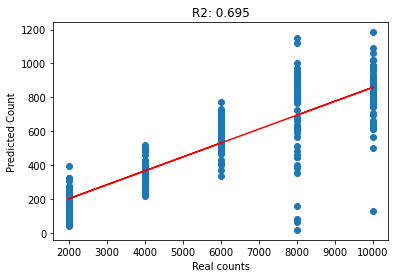

In [38]:
linear_regression(df, 'scatter.png')

In [29]:
result = df.pivot(index)
hotmap = sns.heatmap()
df['filename'].iloc[0]
temp = df.sort_values(['wellID']) # sorts by wellID

0.6948798937741318

In [80]:
real_dirs = glob.glob('data/assayplate_3765/')
REG = r'_([A-Z][0-9]{2})_'
model = models.Cellpose(gpu=True, model_type='cyto')

def well_meta(reg, filename):
    wellId = re.findall(reg, filename)
    return wellId[0]

def df_data(path, model, reg):
    """
    creates data from a list of directories generated into a dict to convert to a pandas dataframe
    PARAMS:
        path - directory of data
        model - cellpose model
    RETURN:
        data - pandas dataframe of filename, groupID, wellID, counts
    """  
    files = glob.glob(path+'/*.tif')
    
    data = {
        'filename':[],
        'wellID':[],
        'counts':[]
    }
    
    print(path)
    for f in files:
        wellID = well_meta(reg, f) # data from filename
        img = skimage.io.imread(f) 
        masks, flows, styles, diams = model.eval(img, diameter=None, channels=[0,0],  do_3D=False)        
        masks=np.array(masks) # convert to numpy array
        count = masks.max()
        
        # append data into dict
        data['filename'].append(f)
        data['wellID'].append(wellID)
        data['counts'].append(count)
    
    df = pd.DataFrame.from_dict(data)
    
    return df

def df_gen(dirs, model,reg):
    """
    creates dataframe of cell data from list of directories
    args:
        dirs - list of directories
        reg - REGEX pattern
    reutrn:
        df - dataframe of cell data: filename, groupID, wellID, counts
    """
    col_names = ['filename','wellID','counts']
    df = pd.DataFrame(columns=col_names)
    for i, d in enumerate(dirs):
        print(f'\n\nGetting data from {d}\n\n')
        data = df_data(d, model, reg)
        df = df.append(data)
    return df

** TORCH CUDA version installed and working. **
>>>> using GPU


In [81]:
df2 = df_gen(real_dirs, model,REG)



Getting data from data/assayplate_3765/


data/assayplate_3765/
processing 1 image(s)
computing styles from images
time spent: running network 0.98s; flow+mask computation 31.71
estimated cell diameters for 1 image(s) in 33.83 sec
>>> diameter(s) =  [31.91538243]


/home/ben/.local/lib/python3.6/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


time spent: running network 3.44s; flow+mask computation 15.80
estimated masks for 1 image(s) in 19.30 sec
>>>> TOTAL TIME 53.13 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.38s; flow+mask computation 42.12
estimated cell diameters for 1 image(s) in 44.61 sec
>>> diameter(s) =  [28.15300142]
time spent: running network 4.13s; flow+mask computation 20.12
estimated masks for 1 image(s) in 24.31 sec
>>>> TOTAL TIME 68.93 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.84s; flow+mask computation 5.00
estimated cell diameters for 1 image(s) in 7.03 sec
>>> diameter(s) =  [32.52786593]
time spent: running network 3.49s; flow+mask computation 4.22
estimated masks for 1 image(s) in 7.79 sec
>>>> TOTAL TIME 14.82 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.76s; flow+mask computation 15.76
estimated cell diameters for 1 image(s) in 17.64 sec
>>> diameter(s) =  [34.96154978]
time 

time spent: running network 4.78s; flow+mask computation 21.08
estimated masks for 1 image(s) in 25.93 sec
>>>> TOTAL TIME 71.05 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.44s; flow+mask computation 43.54
estimated cell diameters for 1 image(s) in 46.21 sec
>>> diameter(s) =  [28.65727667]
time spent: running network 4.43s; flow+mask computation 19.55
estimated masks for 1 image(s) in 24.06 sec
>>>> TOTAL TIME 70.27 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.53s; flow+mask computation 50.45
estimated cell diameters for 1 image(s) in 53.15 sec
>>> diameter(s) =  [26.55889131]
time spent: running network 4.86s; flow+mask computation 21.66
estimated masks for 1 image(s) in 26.59 sec
>>>> TOTAL TIME 79.74 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.67s; flow+mask computation 18.78
estimated cell diameters for 1 image(s) in 20.60 sec
>>> diameter(s) =  [30.27759026]
t

time spent: running network 4.08s; flow+mask computation 19.43
estimated masks for 1 image(s) in 23.57 sec
>>>> TOTAL TIME 67.37 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.15s; flow+mask computation 36.43
estimated cell diameters for 1 image(s) in 38.74 sec
>>> diameter(s) =  [30.06659403]
time spent: running network 3.47s; flow+mask computation 15.22
estimated masks for 1 image(s) in 18.75 sec
>>>> TOTAL TIME 57.49 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.33s; flow+mask computation 46.57
estimated cell diameters for 1 image(s) in 49.03 sec
>>> diameter(s) =  [28.14169499]
time spent: running network 4.08s; flow+mask computation 21.31
estimated masks for 1 image(s) in 25.46 sec
>>>> TOTAL TIME 74.49 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.52s; flow+mask computation 19.23
estimated cell diameters for 1 image(s) in 21.88 sec
>>> diameter(s) =  [25.28173751]
t

time spent: running network 4.09s; flow+mask computation 21.78
estimated masks for 1 image(s) in 25.94 sec
>>>> TOTAL TIME 78.34 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.33s; flow+mask computation 32.35
estimated cell diameters for 1 image(s) in 34.77 sec
>>> diameter(s) =  [27.10459772]
time spent: running network 4.13s; flow+mask computation 18.98
estimated masks for 1 image(s) in 23.16 sec
>>>> TOTAL TIME 57.94 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.68s; flow+mask computation 16.80
estimated cell diameters for 1 image(s) in 18.65 sec
>>> diameter(s) =  [32.54743156]
time spent: running network 3.47s; flow+mask computation 13.41
estimated masks for 1 image(s) in 16.96 sec
>>>> TOTAL TIME 35.60 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.52s; flow+mask computation 45.72
estimated cell diameters for 1 image(s) in 48.37 sec
>>> diameter(s) =  [27.09284886]
t

time spent: running network 4.13s; flow+mask computation 21.14
estimated masks for 1 image(s) in 25.34 sec
>>>> TOTAL TIME 75.14 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.34s; flow+mask computation 28.28
estimated cell diameters for 1 image(s) in 30.74 sec
>>> diameter(s) =  [26.48688334]
time spent: running network 4.77s; flow+mask computation 16.24
estimated masks for 1 image(s) in 21.07 sec
>>>> TOTAL TIME 51.81 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.34s; flow+mask computation 18.23
estimated cell diameters for 1 image(s) in 20.65 sec
>>> diameter(s) =  [26.53491037]
time spent: running network 4.79s; flow+mask computation 12.06
estimated masks for 1 image(s) in 16.90 sec
>>>> TOTAL TIME 37.55 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.13s; flow+mask computation 35.35
estimated cell diameters for 1 image(s) in 37.59 sec
>>> diameter(s) =  [29.47856633]
t

time spent: running network 3.45s; flow+mask computation 15.91
estimated masks for 1 image(s) in 19.42 sec
>>>> TOTAL TIME 53.17 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.16s; flow+mask computation 46.78
estimated cell diameters for 1 image(s) in 49.09 sec
>>> diameter(s) =  [28.11906395]
time spent: running network 4.13s; flow+mask computation 22.46
estimated masks for 1 image(s) in 26.66 sec
>>>> TOTAL TIME 75.75 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.53s; flow+mask computation 33.84
estimated cell diameters for 1 image(s) in 36.49 sec
>>> diameter(s) =  [26.63070458]
time spent: running network 4.78s; flow+mask computation 19.16
estimated masks for 1 image(s) in 24.00 sec
>>>> TOTAL TIME 60.49 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.18s; flow+mask computation 39.58
estimated cell diameters for 1 image(s) in 41.90 sec
>>> diameter(s) =  [29.31614267]
t

time spent: running network 4.04s; flow+mask computation 18.26
estimated masks for 1 image(s) in 22.36 sec
>>>> TOTAL TIME 53.49 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.98s; flow+mask computation 33.48
estimated cell diameters for 1 image(s) in 35.62 sec
>>> diameter(s) =  [31.49370739]
time spent: running network 3.44s; flow+mask computation 15.02
estimated masks for 1 image(s) in 18.54 sec
>>>> TOTAL TIME 54.16 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.81s; flow+mask computation 23.13
estimated cell diameters for 1 image(s) in 25.08 sec
>>> diameter(s) =  [30.86070608]
time spent: running network 3.43s; flow+mask computation 18.75
estimated masks for 1 image(s) in 22.24 sec
>>>> TOTAL TIME 47.33 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.80s; flow+mask computation 23.84
estimated cell diameters for 1 image(s) in 25.81 sec
>>> diameter(s) =  [30.14060888]
t

time spent: running network 3.60s; flow+mask computation 18.62
estimated masks for 1 image(s) in 22.30 sec
>>>> TOTAL TIME 65.13 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.80s; flow+mask computation 23.04
estimated cell diameters for 1 image(s) in 24.96 sec
>>> diameter(s) =  [31.08679486]
time spent: running network 3.37s; flow+mask computation 15.17
estimated masks for 1 image(s) in 18.60 sec
>>>> TOTAL TIME 43.56 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.54s; flow+mask computation 22.90
estimated cell diameters for 1 image(s) in 25.62 sec
>>> diameter(s) =  [24.14835432]
time spent: running network 5.50s; flow+mask computation 18.46
estimated masks for 1 image(s) in 24.04 sec
>>>> TOTAL TIME 49.66 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.98s; flow+mask computation 28.52
estimated cell diameters for 1 image(s) in 30.61 sec
>>> diameter(s) =  [31.85548488]
t

time spent: running network 3.53s; flow+mask computation 15.96
estimated masks for 1 image(s) in 19.57 sec
>>>> TOTAL TIME 37.52 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.67s; flow+mask computation 14.11
estimated cell diameters for 1 image(s) in 15.88 sec
>>> diameter(s) =  [31.27056076]
time spent: running network 3.42s; flow+mask computation 15.51
estimated masks for 1 image(s) in 18.99 sec
>>>> TOTAL TIME 34.87 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.98s; flow+mask computation 31.92
estimated cell diameters for 1 image(s) in 33.99 sec
>>> diameter(s) =  [29.55404987]
time spent: running network 3.45s; flow+mask computation 17.76
estimated masks for 1 image(s) in 21.26 sec
>>>> TOTAL TIME 55.25 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.15s; flow+mask computation 41.82
estimated cell diameters for 1 image(s) in 44.09 sec
>>> diameter(s) =  [28.85651854]
t

time spent: running network 4.83s; flow+mask computation 23.06
estimated masks for 1 image(s) in 27.96 sec
>>>> TOTAL TIME 72.45 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.55s; flow+mask computation 11.83
estimated cell diameters for 1 image(s) in 13.53 sec
>>> diameter(s) =  [33.32063749]
time spent: running network 3.28s; flow+mask computation 12.71
estimated masks for 1 image(s) in 16.07 sec
>>>> TOTAL TIME 29.59 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.36s; flow+mask computation 42.44
estimated cell diameters for 1 image(s) in 44.93 sec
>>> diameter(s) =  [27.98289335]
time spent: running network 4.37s; flow+mask computation 19.74
estimated masks for 1 image(s) in 24.17 sec
>>>> TOTAL TIME 69.10 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.90s; flow+mask computation 20.80
estimated cell diameters for 1 image(s) in 22.94 sec
>>> diameter(s) =  [30.8297456]
ti

time spent: running network 4.80s; flow+mask computation 21.54
estimated masks for 1 image(s) in 26.41 sec
>>>> TOTAL TIME 63.90 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.32s; flow+mask computation 43.21
estimated cell diameters for 1 image(s) in 45.66 sec
>>> diameter(s) =  [28.65727667]
time spent: running network 4.06s; flow+mask computation 18.54
estimated masks for 1 image(s) in 22.68 sec
>>>> TOTAL TIME 68.33 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.33s; flow+mask computation 40.73
estimated cell diameters for 1 image(s) in 43.19 sec
>>> diameter(s) =  [28.20947918]
time spent: running network 4.09s; flow+mask computation 18.27
estimated masks for 1 image(s) in 22.44 sec
>>>> TOTAL TIME 65.63 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.83s; flow+mask computation 21.40
estimated cell diameters for 1 image(s) in 23.38 sec
>>> diameter(s) =  [32.13405158]
t

time spent: running network 4.04s; flow+mask computation 16.27
estimated masks for 1 image(s) in 20.37 sec
>>>> TOTAL TIME 61.02 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.97s; flow+mask computation 29.38
estimated cell diameters for 1 image(s) in 31.50 sec
>>> diameter(s) =  [32.96528262]
time spent: running network 2.88s; flow+mask computation 13.19
estimated masks for 1 image(s) in 16.14 sec
>>>> TOTAL TIME 47.64 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.67s; flow+mask computation 16.84
estimated cell diameters for 1 image(s) in 18.66 sec
>>> diameter(s) =  [30.98423174]
time spent: running network 3.44s; flow+mask computation 16.98
estimated masks for 1 image(s) in 20.49 sec
>>>> TOTAL TIME 39.15 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.15s; flow+mask computation 37.26
estimated cell diameters for 1 image(s) in 39.53 sec
>>> diameter(s) =  [29.94991062]
t

time spent: running network 4.08s; flow+mask computation 16.94
estimated masks for 1 image(s) in 21.09 sec
>>>> TOTAL TIME 57.81 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.34s; flow+mask computation 22.38
estimated cell diameters for 1 image(s) in 24.82 sec
>>> diameter(s) =  [27.91455895]
time spent: running network 4.07s; flow+mask computation 14.92
estimated masks for 1 image(s) in 19.06 sec
>>>> TOTAL TIME 43.88 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.14s; flow+mask computation 9.69
estimated cell diameters for 1 image(s) in 11.95 sec
>>> diameter(s) =  [28.88948897]
time spent: running network 4.03s; flow+mask computation 7.00
estimated masks for 1 image(s) in 11.10 sec
>>>> TOTAL TIME 23.05 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.67s; flow+mask computation 14.49
estimated cell diameters for 1 image(s) in 16.26 sec
>>> diameter(s) =  [34.53098245]
tim

time spent: running network 3.36s; flow+mask computation 16.02
estimated masks for 1 image(s) in 19.44 sec
>>>> TOTAL TIME 36.39 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.67s; flow+mask computation 5.56
estimated cell diameters for 1 image(s) in 7.37 sec
>>> diameter(s) =  [32.66452693]
time spent: running network 2.86s; flow+mask computation 4.78
estimated masks for 1 image(s) in 7.71 sec
>>>> TOTAL TIME 15.08 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.34s; flow+mask computation 38.04
estimated cell diameters for 1 image(s) in 40.46 sec
>>> diameter(s) =  [27.19837546]
time spent: running network 4.12s; flow+mask computation 19.72
estimated masks for 1 image(s) in 23.89 sec
>>>> TOTAL TIME 64.35 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.15s; flow+mask computation 38.60
estimated cell diameters for 1 image(s) in 40.91 sec
>>> diameter(s) =  [29.44615645]
time 

time spent: running network 4.71s; flow+mask computation 19.81
estimated masks for 1 image(s) in 24.59 sec
>>>> TOTAL TIME 67.40 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.53s; flow+mask computation 41.41
estimated cell diameters for 1 image(s) in 44.08 sec
>>> diameter(s) =  [26.74996494]
time spent: running network 4.74s; flow+mask computation 21.61
estimated masks for 1 image(s) in 26.42 sec
>>>> TOTAL TIME 70.49 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.74s; flow+mask computation 32.84
estimated cell diameters for 1 image(s) in 35.69 sec
>>> diameter(s) =  [23.28948359]
time spent: running network 5.50s; flow+mask computation 24.88
estimated masks for 1 image(s) in 30.44 sec
>>>> TOTAL TIME 66.12 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.80s; flow+mask computation 23.16
estimated cell diameters for 1 image(s) in 25.06 sec
>>> diameter(s) =  [31.26037823]
t

time spent: running network 4.72s; flow+mask computation 17.29
estimated masks for 1 image(s) in 22.08 sec
>>>> TOTAL TIME 51.61 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.15s; flow+mask computation 34.84
estimated cell diameters for 1 image(s) in 37.11 sec
>>> diameter(s) =  [30.81942083]
time spent: running network 3.42s; flow+mask computation 14.46
estimated masks for 1 image(s) in 17.94 sec
>>>> TOTAL TIME 55.05 sec
processing 1 image(s)
computing styles from images
time spent: running network 0.80s; flow+mask computation 23.14
estimated cell diameters for 1 image(s) in 25.06 sec
>>> diameter(s) =  [30.70559844]
time spent: running network 3.39s; flow+mask computation 16.43
estimated masks for 1 image(s) in 19.90 sec
>>>> TOTAL TIME 44.96 sec
processing 1 image(s)
computing styles from images
time spent: running network 1.55s; flow+mask computation 39.72
estimated cell diameters for 1 image(s) in 42.44 sec
>>> diameter(s) =  [25.65667252]
t

In [82]:
df2.to_csv('assayPlate_3765.csv', index=False)

In [64]:
type(model)

cellpose.models.Cellpose

In [83]:
df

,filename,groupID,wellID,counts
0,data/INS1_BF/6000/3765_D10_T0001F001L01A01Z01C...,6000,D10,700
1,data/INS1_BF/6000/3765_O09_T0001F001L01A01Z01C...,6000,O09,626
2,data/INS1_BF/6000/3765_J12_T0001F001L01A01Z01C...,6000,J12,628
3,data/INS1_BF/6000/3765_N10_T0001F001L01A01Z01C...,6000,N10,586
4,data/INS1_BF/6000/3765_J10_T0001F001L01A01Z01C...,6000,J10,571
...,...,...,...,...
315,data/INS1_BF/8000/3765_J06_T0001F001L01A01Z01C...,8000,J06,623
316,data/INS1_BF/8000/3765_H07_T0001F001L01A01Z01C...,8000,H07,926
317,data/INS1_BF/8000/3765_E06_T0001F001L01A01Z01C...,8000,E06,858
318,data/INS1_BF/8000/3765_N08_T0001F001L01A01Z01C...,8000,N08,926


In [86]:
df2.dtypes

filename    object
wellID      object
counts      object
dtype: object

In [151]:
df_heat = pd.read_csv('assayPlate_3765.csv')

In [152]:
df_heat.dtypes

filename    object
wellID      object
counts       int64
dtype: object

In [154]:
dt = df_heat
dt.head(5)

,filename,wellID,counts
0,data/assayplate_3765/AssayPlate_Corning_3765_M...,M01,1016
1,data/assayplate_3765/AssayPlate_Corning_3765_L...,L23,648
2,data/assayplate_3765/AssayPlate_Corning_3765_F...,F21,202
3,data/assayplate_3765/AssayPlate_Corning_3765_A...,A21,946
4,data/assayplate_3765/AssayPlate_Corning_3765_O...,O19,431


In [159]:
dt[['well','wellNum']] = df_heat['wellID'].str.extract('([A-Z])([0-9]{2})',expand=True)

In [160]:
df_heat.head(5)

,filename,wellID,counts,well,wellNum
0,data/assayplate_3765/AssayPlate_Corning_3765_M...,M01,1016,M,01
1,data/assayplate_3765/AssayPlate_Corning_3765_L...,L23,648,L,23
2,data/assayplate_3765/AssayPlate_Corning_3765_F...,F21,202,F,21
3,data/assayplate_3765/AssayPlate_Corning_3765_A...,A21,946,A,21
4,data/assayplate_3765/AssayPlate_Corning_3765_O...,O19,431,O,19


In [161]:
dt = dt.sort_values('well')

In [163]:
dt.sort_values('wellNum')

,filename,wellID,counts,well,wellNum
183,data/assayplate_3765/AssayPlate_Corning_3765_G...,G01,1026,G,01
68,data/assayplate_3765/AssayPlate_Corning_3765_N...,N01,897,N,01
70,data/assayplate_3765/AssayPlate_Corning_3765_J...,J01,1175,J,01
0,data/assayplate_3765/AssayPlate_Corning_3765_M...,M01,1016,M,01
305,data/assayplate_3765/AssayPlate_Corning_3765_A...,A01,1534,A,01
...,...,...,...,...,...
138,data/assayplate_3765/AssayPlate_Corning_3765_A...,A24,263,A,24
34,data/assayplate_3765/AssayPlate_Corning_3765_H...,H24,1027,H,24
262,data/assayplate_3765/AssayPlate_Corning_3765_C...,C24,873,C,24
215,data/assayplate_3765/AssayPlate_Corning_3765_D...,D24,936,D,24


In [164]:
dh = pd.pivot_table(data=dt,index='well',values='counts',columns='wellNum')

In [165]:
dh.head()

wellNum,01,02,03,04,05,06,07,08,09,10,...,15,16,17,18,19,20,21,22,23,24
well,,,,,,,,,,,,,,,,,,,,,
A,1534,1380,1004,1150,1216,1203,1123,1109,1274,1358,...,1150,1159,1175,1148,1122,1188,946,810,688,263
B,1465,1348,841,844,1100,1408,1397,1622,1381,1184,...,1296,1196,1244,1316,1452,1176,962,723,663,837
C,1669,1288,713,875,1169,1218,1442,1565,1351,1275,...,1119,1330,1299,1439,1313,1077,978,948,927,873
D,1061,870,778,699,896,1083,1311,1427,1230,1186,...,1161,1326,1388,1334,1126,1055,896,834,903,936
E,1159,1034,604,735,878,1051,1404,1364,1300,1273,...,1027,1362,1357,1607,1226,919,872,662,136,1110


Text(0.5, 1.0, 'SMM-20-B09-5000nM Assay Plate Corning 3765')

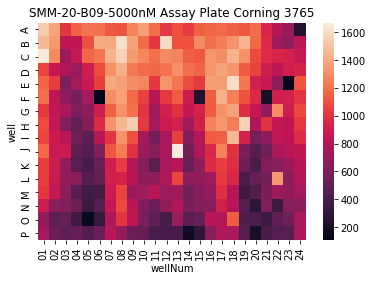

In [168]:
heat = sns.heatmap(dh)
heat.set_title('SMM-20-B09-5000nM Assay Plate Corning 3765')

In [170]:
fig = heat.get_figure()
fig.savefig('heatmap.png')

In [171]:
df2.dtypes

filename    object
wellID      object
counts      object
dtype: object

In [177]:
temp = df2

In [178]:
temp.counts = temp.counts.astype('int64')

In [179]:
temp.dtypes

filename    object
wellID      object
counts       int64
dtype: object

In [182]:
dt.to_csv('split_data.csv',index=False)

In [187]:
n = dt.sort_values('counts').head(5).iloc[0]

In [188]:
n

filename    data/assayplate_3765/AssayPlate_Corning_3765_F...
wellID                                                    F06
counts                                                    106
well                                                        F
wellNum                                                    06
Name: 324, dtype: object

In [189]:
type(n)

pandas.core.series.Series

In [190]:
n.values

array(['data/assayplate_3765/AssayPlate_Corning_3765_F06_T0001F001L01A01Z01C01.tif',
       'F06', 106, 'F', '06'], dtype=object)

In [191]:
n = dt.sort_values('counts',ascending=False).head(5).iloc[0]

In [193]:
n.values

array(['data/assayplate_3765/AssayPlate_Corning_3765_C01_T0001F001L01A01Z01C01.tif',
       'C01', 1669, 'C', '01'], dtype=object)

In [216]:
n = dt.sort_values('counts').iloc[:15]

In [221]:
t = n['filename'].iloc[:5]